# 04 Hotel Database
## Assignment

Design, populate, and query a database for a hotel reservation system with the following business rules:

1. The hotel has a number of rooms of two types: Deluxe and Suite
2. For every night, some rooms are made available for reservation for a specific price.
3. A guest can make a reservation for an avavilable room for one night. The reservation must include credit card payment info. At most one reservation can be made per night per room.
4. A guest can check into a room that has been reserved. An attempt to check in without a reservation will generate an error.
5. A guest can check out only after checking in. An attempt to check out multiple times or check out without checking in will generate an error.

Your Python code should provide the following:

1. A section to create the tables. The design must be in 3rd normal form following the conventions discussed in class and enforcing the business rules above.

2. Provide code to populate rooms and room availability with prices.

3. The function `reserve_room(room, date, guest_name, credit_card)` to make a reservation. A script that populates at least 300 reservations (e.g. use `faker`)

4. The functions `checkin(room, date)` and `checkout(room, date)` to check guests in and out. Write a script that invokes `checkin` and `checkout` for a buncha guests.  Demonstrate that that the functions enforces the rules of the business.

5. Write a query to list all guests who have stayed in a given room in 2021.

6. Write a query to list all dates on which a specific guest stayed at the hotel.



# Define the database

In [1]:
import datajoint as dj
schema = dj.Schema('hotel')

[2024-09-09 19:34:13,205][INFO]: Connecting root@localhost:3306
[2024-09-09 19:34:13,223][INFO]: Connected root@localhost:3306


In [2]:
@schema
class Room(dj.Manual):
    definition = """
    room : int
    --- 
    room_type : enum('Deluxe', 'Suite')
    """

In [3]:
@schema
class RoomAvailable(dj.Manual):
    definition = """
    -> Room
    date : date 
    ---
    price : decimal(6, 2)
    """

In [4]:
@schema
class Guest(dj.Manual):
    definition = """
    guest_id : int unsigned
    --- 
    guest_name : varchar(60)
    index(guest_name)
    """

In [5]:
@schema
class Reservation(dj.Manual):
    definition = """
    -> RoomAvailable
    ---
    -> Guest
    credit_card : varchar(80)
    """

In [6]:
@schema
class CheckIn(dj.Manual):
    definition = """
    -> Reservation
    """

In [7]:
@schema
class CheckOut(dj.Manual):
    definition = """
    -> CheckIn
    """

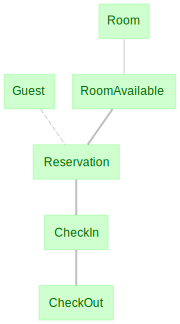

In [8]:
dj.Diagram(schema)

# Populate Room Availability

In [9]:
import faker
import random
import datetime
import tqdm
fake = faker.Faker()

In [10]:
# populate rooms
Room.insert((i, "Deluxe" if i%2 else "Suite") for i in range(80))

In [11]:
# Populate Room availability: 45 days starting on start_date
start_date = datetime.date(2023, 11, 1)
days = 45

for day in tqdm.tqdm(range(days)):
    price = random.randint(40, 350) 
    RoomAvailable.insert(
        dict(key, 
             date=start_date + datetime.timedelta(days=day), 
             price=price) for key in Room.fetch('KEY'))
    

100%|██████████| 45/45 [00:00<00:00, 136.84it/s]


# Functions 

In [12]:
class HotelException(Exception): pass
class RoomUnavailable(HotelException): pass
class RoomAlreadyReserved(HotelException): pass
class AlreadyChecked(HotelException): pass
class NoReservation(HotelException): pass
class NotCheckedIn(HotelException): pass

In [13]:
def reserve_room(room, date, guest_name, credit_card):
    # lookup guest by name
    keys = (Guest & {'guest_name': guest_name}).fetch('KEY')
    
    if keys:
        # if multiple found, use the first, for example
        key = keys[0]  
    else:
        # if not registered before, create a new guest id
        key = dict(guest_id=random.randint(0, 2**32-1))
        Guest.insert1(dict(key, guest_name=guest_name))
    
    try:
        Reservation.insert1(
            dict(key, room=room, date=date, credit_card=credit_card))
    except dj.errors.DuplicateError:
        raise RoomAlreadyReserved(room, date.isoformat()) from None
    except dj.errors.IntegrityError:
        raise RoomUnavailable(room, date.isoformat()) from None

In [14]:
def check_in(room, date):
    try:
        CheckIn.insert1(dict(room=room, date=date))
    except dj.errors.DuplicateError:
        raise AlreadyChecked(room, date.isoformat()) from None
    except dj.errors.IntegrityError:
        raise NoReservation(room, date.isoformat()) from None

In [15]:
def check_out(room, date):
    try:
        CheckOut.insert1(dict(room=room, date=date))
    except dj.errors.DuplicateError:
        raise AlreadyChecked(room, date.isoformat()) from None
    except dj.errors.IntegrityError:
        raise NotCheckedIn(room, date.isoformat()) from None

# Operations

In [16]:
# make a bunch of random reservations

number_of_guests = 100
max_nights = 20

for i in tqdm.tqdm(range(number_of_guests)):
    guest = fake.name()
    credit_card=' '.join((fake.credit_card_number(), 
                          fake.credit_card_expire(), 
                          fake.credit_card_security_code()))
    
    for j in range(random.randint(1, max_nights)):
        date =  fake.date_between_dates(start_date, start_date+datetime.timedelta(days=45))
        room = random.randint(0, 80)
        try:
            reserve_room(room, date, guest, credit_card)
        except HotelException as e:
            print(repr(e))
            
# show successful reservations
Reservation()

  2%|▏         | 2/100 [00:00<00:07, 12.98it/s]

RoomUnavailable(80, '2023-11-16')
RoomAlreadyReserved(33, '2023-11-09')


 10%|█         | 10/100 [00:00<00:03, 26.86it/s]

RoomAlreadyReserved(66, '2023-11-30')


 17%|█▋        | 17/100 [00:00<00:03, 25.50it/s]

RoomAlreadyReserved(73, '2023-12-01')
RoomUnavailable(80, '2023-11-14')
RoomAlreadyReserved(32, '2023-12-09')
RoomUnavailable(80, '2023-11-15')


 22%|██▏       | 22/100 [00:00<00:02, 28.09it/s]

RoomAlreadyReserved(60, '2023-12-07')
RoomUnavailable(80, '2023-11-29')
RoomAlreadyReserved(39, '2023-11-02')
RoomAlreadyReserved(16, '2023-11-15')
RoomAlreadyReserved(45, '2023-11-30')
RoomAlreadyReserved(17, '2023-11-25')
RoomAlreadyReserved(17, '2023-11-25')


 28%|██▊       | 28/100 [00:01<00:02, 25.85it/s]

RoomAlreadyReserved(78, '2023-12-08')
RoomAlreadyReserved(64, '2023-11-26')
RoomAlreadyReserved(43, '2023-12-05')
RoomAlreadyReserved(9, '2023-11-15')
RoomAlreadyReserved(65, '2023-11-04')
RoomAlreadyReserved(41, '2023-11-13')
RoomUnavailable(80, '2023-11-14')


 34%|███▍      | 34/100 [00:01<00:02, 27.07it/s]

RoomAlreadyReserved(27, '2023-12-10')
RoomUnavailable(80, '2023-11-24')
RoomAlreadyReserved(72, '2023-11-22')
RoomAlreadyReserved(40, '2023-11-30')
RoomAlreadyReserved(29, '2023-11-02')
RoomUnavailable(80, '2023-11-26')
RoomAlreadyReserved(28, '2023-11-08')
RoomAlreadyReserved(18, '2023-11-17')


 41%|████      | 41/100 [00:01<00:02, 26.66it/s]

RoomAlreadyReserved(18, '2023-12-01')
RoomAlreadyReserved(15, '2023-11-22')
RoomAlreadyReserved(11, '2023-11-04')
RoomAlreadyReserved(38, '2023-12-03')
RoomAlreadyReserved(42, '2023-11-07')


 49%|████▉     | 49/100 [00:01<00:01, 31.25it/s]

RoomUnavailable(80, '2023-11-06')
RoomAlreadyReserved(73, '2023-11-18')
RoomAlreadyReserved(17, '2023-12-09')
RoomUnavailable(80, '2023-11-11')
RoomAlreadyReserved(74, '2023-11-13')
RoomAlreadyReserved(26, '2023-11-13')
RoomAlreadyReserved(24, '2023-12-02')
RoomAlreadyReserved(1, '2023-12-12')
RoomAlreadyReserved(16, '2023-11-15')


 57%|█████▋    | 57/100 [00:02<00:01, 30.16it/s]

RoomUnavailable(80, '2023-11-20')
RoomAlreadyReserved(74, '2023-11-13')
RoomAlreadyReserved(40, '2023-11-30')
RoomAlreadyReserved(7, '2023-12-14')
RoomAlreadyReserved(53, '2023-11-21')
RoomAlreadyReserved(50, '2023-11-22')
RoomAlreadyReserved(12, '2023-11-09')
RoomAlreadyReserved(60, '2023-11-18')
RoomAlreadyReserved(14, '2023-11-05')


 61%|██████    | 61/100 [00:02<00:01, 27.72it/s]

RoomAlreadyReserved(37, '2023-11-20')
RoomAlreadyReserved(19, '2023-11-19')
RoomAlreadyReserved(52, '2023-11-02')
RoomUnavailable(80, '2023-11-24')
RoomAlreadyReserved(37, '2023-12-07')
RoomAlreadyReserved(6, '2023-11-30')
RoomAlreadyReserved(41, '2023-11-29')
RoomAlreadyReserved(39, '2023-11-02')
RoomAlreadyReserved(9, '2023-11-25')
RoomAlreadyReserved(47, '2023-12-09')
RoomUnavailable(80, '2023-11-11')


 68%|██████▊   | 68/100 [00:02<00:01, 30.23it/s]

RoomAlreadyReserved(73, '2023-12-08')
RoomAlreadyReserved(39, '2023-11-14')
RoomAlreadyReserved(0, '2023-11-28')
RoomAlreadyReserved(54, '2023-11-27')
RoomAlreadyReserved(40, '2023-11-29')
RoomAlreadyReserved(66, '2023-12-05')


 72%|███████▏  | 72/100 [00:02<00:00, 29.96it/s]

RoomAlreadyReserved(59, '2023-11-14')
RoomAlreadyReserved(0, '2023-11-13')
RoomAlreadyReserved(55, '2023-12-01')
RoomAlreadyReserved(44, '2023-11-14')
RoomAlreadyReserved(3, '2023-11-17')
RoomAlreadyReserved(11, '2023-11-22')
RoomAlreadyReserved(9, '2023-11-27')
RoomAlreadyReserved(29, '2023-11-26')
RoomAlreadyReserved(77, '2023-11-21')
RoomAlreadyReserved(21, '2023-11-01')
RoomAlreadyReserved(7, '2023-12-08')
RoomAlreadyReserved(68, '2023-12-10')
RoomAlreadyReserved(54, '2023-11-09')
RoomAlreadyReserved(29, '2023-11-02')
RoomAlreadyReserved(22, '2023-11-09')
RoomAlreadyReserved(26, '2023-11-10')
RoomAlreadyReserved(50, '2023-11-15')
RoomAlreadyReserved(3, '2023-11-17')
RoomAlreadyReserved(7, '2023-11-12')
RoomAlreadyReserved(47, '2023-12-07')
RoomAlreadyReserved(29, '2023-11-07')


 81%|████████  | 81/100 [00:02<00:00, 32.00it/s]

RoomAlreadyReserved(29, '2023-11-02')
RoomAlreadyReserved(6, '2023-12-12')
RoomAlreadyReserved(74, '2023-11-13')
RoomAlreadyReserved(44, '2023-11-21')
RoomAlreadyReserved(71, '2023-12-03')
RoomAlreadyReserved(34, '2023-11-29')
RoomUnavailable(80, '2023-12-07')
RoomAlreadyReserved(40, '2023-11-03')
RoomAlreadyReserved(21, '2023-11-01')
RoomAlreadyReserved(63, '2023-11-28')
RoomAlreadyReserved(2, '2023-11-09')
RoomAlreadyReserved(63, '2023-12-08')
RoomAlreadyReserved(21, '2023-11-01')
RoomAlreadyReserved(63, '2023-11-28')
RoomAlreadyReserved(77, '2023-12-11')
RoomAlreadyReserved(37, '2023-12-08')


 85%|████████▌ | 85/100 [00:03<00:00, 27.97it/s]

RoomAlreadyReserved(21, '2023-11-25')
RoomAlreadyReserved(1, '2023-11-11')
RoomAlreadyReserved(26, '2023-11-22')
RoomAlreadyReserved(73, '2023-12-08')
RoomAlreadyReserved(22, '2023-11-22')
RoomAlreadyReserved(59, '2023-12-13')
RoomAlreadyReserved(45, '2023-12-07')
RoomAlreadyReserved(75, '2023-11-13')
RoomAlreadyReserved(24, '2023-11-21')
RoomAlreadyReserved(76, '2023-11-21')
RoomAlreadyReserved(78, '2023-12-05')
RoomAlreadyReserved(70, '2023-11-16')
RoomAlreadyReserved(9, '2023-11-16')
RoomAlreadyReserved(42, '2023-11-11')
RoomAlreadyReserved(52, '2023-12-06')
RoomAlreadyReserved(38, '2023-12-11')


 95%|█████████▌| 95/100 [00:03<00:00, 30.57it/s]

RoomAlreadyReserved(75, '2023-11-04')
RoomAlreadyReserved(73, '2023-11-06')
RoomAlreadyReserved(27, '2023-11-05')
RoomAlreadyReserved(9, '2023-11-25')
RoomAlreadyReserved(54, '2023-11-22')
RoomAlreadyReserved(6, '2023-11-26')
RoomAlreadyReserved(44, '2023-11-03')
RoomAlreadyReserved(24, '2023-11-17')
RoomAlreadyReserved(57, '2023-12-13')
RoomAlreadyReserved(10, '2023-11-25')
RoomAlreadyReserved(19, '2023-11-19')
RoomAlreadyReserved(22, '2023-11-09')
RoomAlreadyReserved(55, '2023-11-23')


100%|██████████| 100/100 [00:03<00:00, 28.34it/s]

RoomAlreadyReserved(40, '2023-11-03')
RoomAlreadyReserved(64, '2023-11-22')
RoomAlreadyReserved(0, '2023-12-01')
RoomAlreadyReserved(61, '2023-11-30')
RoomAlreadyReserved(16, '2023-11-26')
RoomAlreadyReserved(57, '2023-12-13')
RoomAlreadyReserved(45, '2023-12-11')


room,date,guest_id,credit_card
0,2023-11-01,3099856893,4507331132753 10/28 837
0,2023-11-07,1622341408,3546676342666627 09/29 439
0,2023-11-11,567871944,378397073548178 07/28 911
0,2023-11-13,2063013418,4822648938879 06/34 795
0,2023-11-14,2784595880,3567864912758065 08/28 465
0,2023-11-15,2279957190,2234004627591809 10/29 4392
0,2023-11-16,931543264,6588615931690152 08/25 369
0,2023-11-26,248810082,3515280157943507 03/34 692
0,2023-11-27,2199078534,30302873990315 04/30 608
0,2023-11-28,754370609,5461237325560497 04/26 0428


In [17]:
Guest()

guest_id,guest_name
4277584367,Aaron Farrell
3494034078,Alan Perry
2631768732,Alexander Maldonado
2205351155,Alexis Thomas
1729093019,Amber Taylor
1233339772,Angela Lamb
754370609,Angela Williams
865017483,Anthony Arellano
2742129731,Ashley Gomez
3250600473,Bianca Wagner


In [18]:
# Try check in
check_in(2, datetime.date(2023, 11, 2))

NoReservation: (2, '2023-11-02')

In [20]:
# checkin a bunch of people
checkins = random.sample(Reservation().fetch('KEY'), k=int(0.9*len(Reservation())))
for r in tqdm.tqdm(checkins):
    try: 
        check_in(**r)
    except AlreadyChecked as e:
        print(repr(e))


  0%|          | 0/828 [00:00<?, ?it/s]

100%|██████████| 828/828 [00:02<00:00, 330.90it/s]


In [21]:
CheckIn()

room,date
0,2023-11-09
0,2023-11-11
0,2023-11-14
0,2023-11-18
0,2023-11-23
0,2023-11-26
0,2023-12-01
0,2023-12-03
0,2023-12-05
0,2023-12-06


In [22]:
# Try duplicate checkin -- should fail 
check_in(**checkins[0])

AlreadyChecked: (46, '2023-11-08')

In [23]:
# Try checkout

check_out(2, datetime.date(2023, 10, 2))

NotCheckedIn: (2, '2023-10-02')

In [24]:
# checkout a bunch of people
checkouts = random.sample(CheckIn().fetch('KEY'), k=int(0.9*len(CheckIn())))
for r in tqdm.tqdm(checkouts):
    try:
        check_out(**r)
    except AlreadyChecked as e:
        print(repr(e))

  4%|▍         | 32/745 [00:00<00:02, 317.79it/s]

100%|██████████| 745/745 [00:02<00:00, 356.68it/s]


In [25]:
# try duplicate checkout -- should fail

check_out(**checkouts[0])

AlreadyChecked: (19, '2023-11-03')